# Lab 2 : Overview

Upon completing this lab, you should have a good understanding of the fundamentals of using OpenStreetmap maps and developing local planners for Autonomous Vehicles, along with practical experience in designing, implementing, and testing local planners in a simulated environment. This hands-on experience will prepare you for further study or work in the field of autonomous vehicles.

In [94]:
# useful imports
import matplotlib.pyplot as plt
from osmnx_utils import *
import osmnx  as ox   
import networkx as nx
import numpy as np

# Task n° 1 : Load and visualize OSM Maps
- This task involves loading an OpenStreetMap (OSM) map for a specified location using the osmnx library.
- It also visualizes the OSM graph, nodes, and edges for the given location 

First, you'll need to find a location of interest in an osm map: https://www.openstreetmap.org

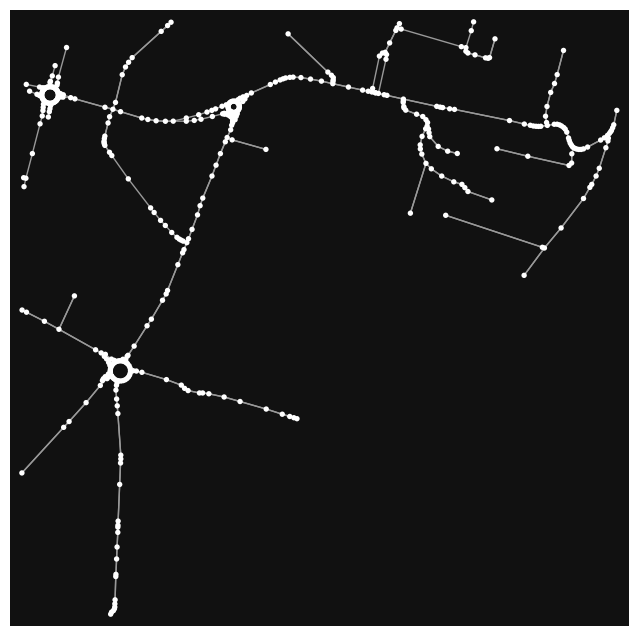

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [95]:
def create_config():
   # Place you are interested : 
    location = (47.2489965, -1.5473425) # Nantes, Ecole Centrale
    mode = "drive"
    #ox.config(log_console=False, use_cache=True)
    

    G_osmnx = ox.graph_from_point(location, dist=500, simplify=False, network_type=mode )
    return(G_osmnx)

G_osmnx = create_config() # This may take a while the first time

# TODO : Plot the graph and nodes according to the osmnx documentation
# TIP : You can use the function osmnx.plot.plot_graph()
ox.plot_graph(G_osmnx)

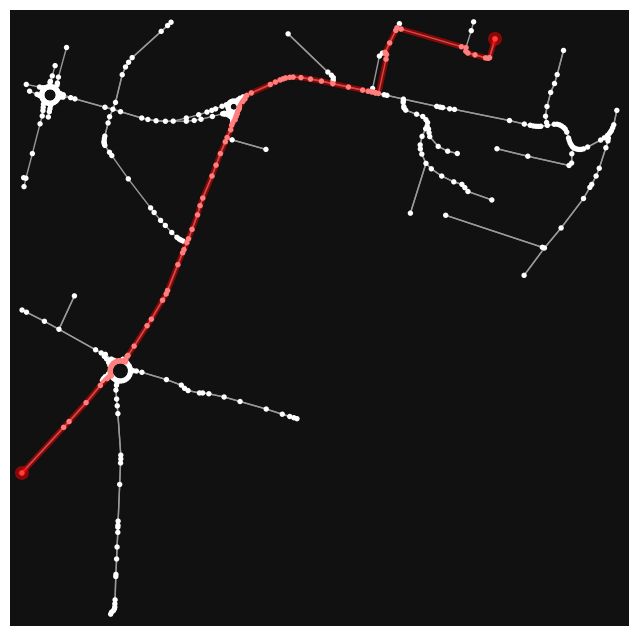

In [96]:
# Arbitrary origin and destination
origin = (round(-1.5562600,6), round(47.2467100,6))
destination = (round(-1.5428700,6), round(47.2533500,6))
origin_node = ox.nearest_nodes(G_osmnx, origin[0], origin[1])
destination_node = ox.nearest_nodes(G_osmnx, destination[0], destination[1])

# find the path from origin to destination, using nx library
path = nx.shortest_path(G_osmnx, origin_node, destination_node, weight='length')

# plot the path on the graph
# TIP : use the function ox.plot_graph_route()
fig, ax = ox.plot_graph_route(G_osmnx, path)

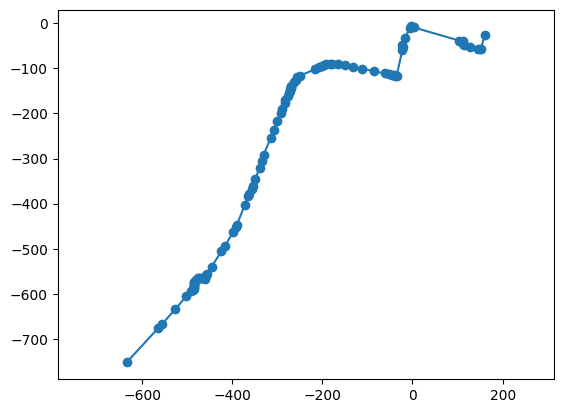

In [97]:
nodes_proj, edges_proj = ox.graph_to_gdfs(G_osmnx, nodes=True, edges=True)

# convert to local coordinates
wpts = gdfs_to_local(nodes_proj, path)
plt.plot(wpts[:,0], wpts[:,1], 'o-')
plt.axis("equal")
plt.show()

# Task 2: Implement a Global Planner
- In this task, you load a pre-existing road network graph (Town 01 Road Network) and actor positions.
- You also create a custom A* algorithm and heuristic function to find a path from the ego vehicle's current position to a specified target

In [98]:
import pickle

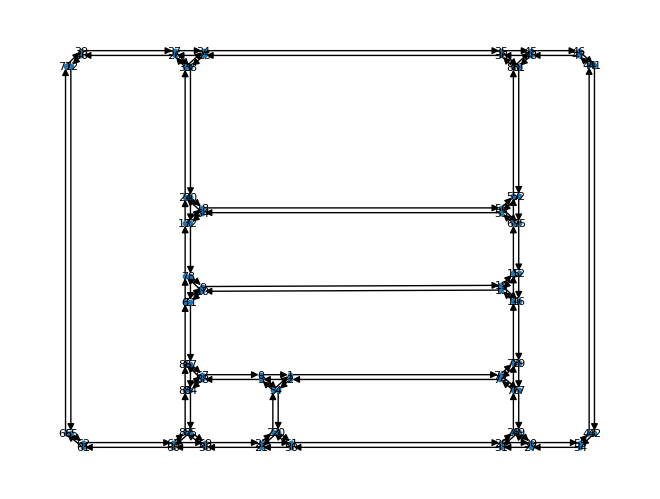

In [99]:
nodes =  pickle.load(open('C:\\Users\\enric\\Desktop\\labs\lab2\\lab2_data\\Town01_nodes.pickle', 'rb'))
edges =  pickle.load(open('C:\\Users\\enric\\Desktop\\labs\\lab2\\lab2_data\\Town01_edges.pickle', 'rb'))

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
node_positions = {waypoint[0]: (waypoint[1]["vertex"][0], waypoint[1]["vertex"][1]) for waypoint in G.nodes.data()}

# Draw the graph via networkx and matplotlib

plt.figure()
nx.draw(G, pos=node_positions, with_labels=True, node_size=10, font_size=8)
plt.show()


In [ ]:
from utils import get_actor_T_world

actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind"]
N_frames = 100


In [101]:
# Define a custom A* algorithm TODO: implement the algorithm
def custom_a_star(graph, start, end, heuristic_func):
    open_set = {start}
    came_from = {}
    g_score = {node: float('inf') for node in graph.nodes}
    g_score[start] = 0
    f_score = {node: float('inf') for node in graph.nodes}
    f_score[start] = heuristic_func(start, end)

    while open_set:
        current = min(open_set, key=lambda node: f_score[node])
        if current == end:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path

        open_set.remove(current)
        for neighbor in graph.neighbors(current):
            tentative_g_score =  g_score[current] + graph[current][neighbor]['length']
            if tentative_g_score < g_score[neighbor]:
                # TODO: update came_from
                came_from[neighbor] = current
                # TODO: update g_score and f_score
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] =  f_score[neighbor] + heuristic_func(neighbor, end)

                # TODO: add neighbor to open_set if not already in
                if neighbor not in open_set:
                    open_set.add(neighbor)
                


    return [start, end]

# Define a custom heuristic function (e.g., Euclidean distance)
def custom_heuristic(node, end):
    #Euclidean distance between node and end
    return np.linalg.norm(np.array(node) - np.array(end))
    

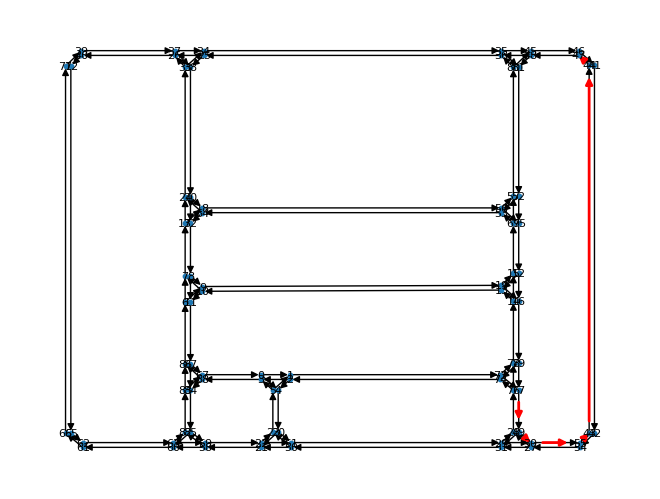

In [102]:
# find closest node to ego vehicle
ego_vehicle = "ego_vehicle"
ego_vehicle_pos = get_actor_T_world(ego_vehicle, 0)
ego_vehicle_pos = ego_vehicle_pos[:2,-1]

def closest_node(G, pos):
    closest_node = min(G.nodes, key=lambda node: ((pos[0] - G.nodes[node]['vertex'][0]) ** 2 + (pos[1] - G.nodes[node]['vertex'][1]) ** 2) ** 0.5)
    return closest_node

origin = closest_node(G, ego_vehicle_pos)
end = 47
path = custom_a_star(G, origin, end, custom_heuristic)


path_edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]

# Draw the graph and the path on top of the graph
# TIP : You can use the nx function draw_network_edges() 

nx.draw(G, pos=node_positions, with_labels=True, node_size=10, font_size=8)
nx.draw_networkx_edges(G, pos=node_positions, edgelist=path_edges, edge_color='r', width=2)

# Task 3: Implement a Local Planner - DWA Approach
- This task implements the Dynamic Window Approach (DWA) for local planning. It defines various parameters such as maximum velocity, acceleration, and rotation.
- It simulates the DWA algorithm to generate a trajectory that minimizes a cost function. The trajectory is then plotted.

In [103]:
# Constants
MAX_VELOCITY = 13.0  # Maximum linear velocity (m/s)
MAX_ACCELERATION = 0.2  # Maximum linear acceleration (m/s^2)
MAX_ROTATION = 2.0  # Maximum rotational velocity (rad/s)

# DWA parameters
NUM_THETA = 11  # Number of angular velocity samples
NUM_V = 11  # Number of linear velocity samples
DT = 0.1  # Time step for simulation

# Function to calculate a cost for a given trajectory, only based on distance to target and speed
def calculate_cost(trajectory, target, obstacles):
    dist_cost = 0
    speed_cost = 0

    # Calculate distance cost to the target at the end of prediction horizon
    final_position = trajectory[-1][:2]
    dist_cost = np.linalg.norm(final_position - target[:2])

    # Calculate speed cost as difference between the last two points of the predicted trajectory divided by the time step
    speed_cost = (np.linalg.norm(trajectory[-2][:2] - trajectory[-1][:2]) ) / DT

    return dist_cost + speed_cost 

# Evolution model 
def evolve(current_state, v, w):
    x, y, theta = current_state
    
    x = x + v * np.cos(theta) * DT
    y = y + v * np.sin(theta) * DT
    theta = theta + w * DT

    return np.array([x, y, theta])

# DWA algorithm
def dynamic_window_approach(current_state, target, obstacles):
    best_trajectory = None
    best_commands = None
    min_cost = float('inf')
# all (v,w) pairs are used to simulate the trajectory, the best one is selected and applied to the robot
    for v in np.linspace(4, MAX_VELOCITY, NUM_V):
        v=-v # Convention sign for the velocity in the dataset
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(10):  # Simulate for 1 second with evolution model
                trajectory.append(evolve(trajectory[-1], v, w))

            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles)

            # Update the best trajectory here
            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory
                best_commands = (v, w)

    return best_trajectory, best_commands

IndexError: list index out of range

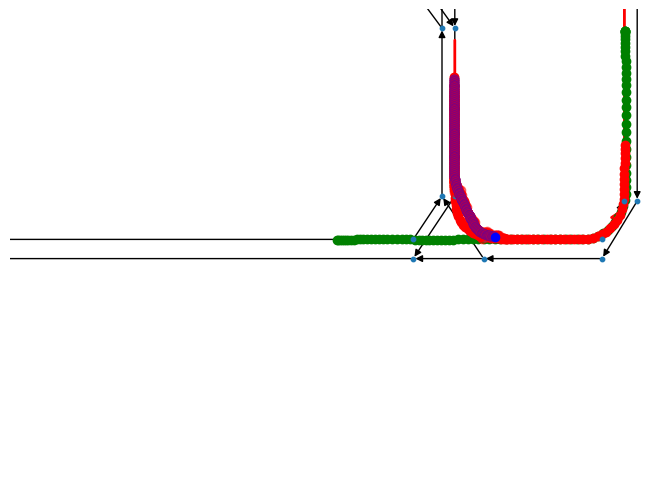

In [104]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)

obstacles = []  # List of obstacle positions, none for now

# Visualize the graph
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)


path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(len(path)-1)] # Loop over the global path
next_waypoint = path_loop.pop(0)
i=0
while path_loop and i<100   :
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)
        
    resulting_trajectory, cmds = dynamic_window_approach(current_state, np.array(next_waypoint), obstacles)
    
    # Move along the trajectory (simulated)
    for state in resulting_trajectory:
        current_state = state
        plt.plot(current_state[0], current_state[1], 'ro', alpha=0.5)

    current_state = resulting_trajectory[1]
    plt.plot(current_state[0], current_state[1], 'bo')
    i+=1

plt.xlim(200,400)
plt.ylim(-50,50)


# TODO: Plot the trajectory of the ego vehicle and the other vehicle
for n_frame in range(N_frames):
    T_ego = get_actor_T_world(ego_vehicle, n_frame)
    ego_x, ego_y = T_ego[:2, -1]
    plt.scatter(ego_x, ego_y, color='r')
    
    T_actor = get_actor_T_world("other_vehicle", n_frame)
    actor_x, actor_y = T_actor[:2, -1]
    plt.scatter(actor_x, actor_y, color='g')

plt.show()

# Task 4: Implement a DWA Approach with Obstacle Avoidance
- This task extends the DWA approach to include obstacle avoidance. Obstacle positions (both static and dynamic) are considered when calculating the cost of a trajectory.
- The code predicts the future positions of dynamic obstacles.
- It then simulates the DWA approach while avoiding both static and dynamic obstacles.

In [ ]:
ROBOT_RADIUS = 3 # Robot radius (m)
OBS_RADIUS = 3  # Radius of obstacles (m)

# Function to calculate a cost for a given trajectory considering proximity to obstacles
def calculate_cost(trajectory, target, obstacles, dynamic_obstacles):
    dist_cost = np.linalg.norm(trajectory[-1][:2] - target[:2])
    speed_cost = 0
    cost = dist_cost + speed_cost
    # Add a penalty for proximity to static obstacles
    for obs in obstacles:
        distances = np.linalg.norm(trajectory[-1][:2] - np.array(obs))
        min_distance = ROBOT_RADIUS + OBS_RADIUS
        cost += max(0, min_distance - distances)

    # Add a penalty for proximity to dynamic obstacles
    for obs in dynamic_obstacles:
        obs_trajectory = predict_dynamic_obstacles(obs, len(trajectory))
        plt.plot(obs_trajectory[1][0], obs_trajectory[1][1], 'ro')
        for i in range(len(trajectory)):
            distance = np.linalg.norm(trajectory[i][:2] - obs_trajectory[i])
            if distance < ROBOT_RADIUS + OBS_RADIUS:
                cost += (ROBOT_RADIUS + OBS_RADIUS - distance)

    return cost

# Function to predict future positions of dynamic obstacles
def predict_dynamic_obstacles(dynamic_obstacle, num_steps):
    x,y,v_x, v_y = dynamic_obstacle
    positions = []

    for _ in range(num_steps):
        x = x + v_x * DT
        y = y + v_y * DT
        positions.append(np.array([x, y]))
    
    return positions

# DWA algorithm with dynamic obstacle avoidance and proximity to obstacles
def dynamic_window_approach_avoidance(current_state, target, obstacles, dynamic_obstacles):
    best_trajectory = None
    min_cost = float('inf')

    # Predict future positions of dynamic obstacles
    num_prediction_steps = 10

    for v in np.linspace(0, MAX_VELOCITY, NUM_V):
        v = -v # Convention sign for the velocity in the dataset
        for w in np.linspace(-MAX_ROTATION, MAX_ROTATION, NUM_THETA):
            # Simulate the trajectory
            trajectory = [np.array(current_state)]
            for _ in range(num_prediction_steps):  # Simulate for predicted time
                x, y, theta = trajectory[-1]
                trajectory.append(evolve(trajectory[-1], v, w))

            # Calculate the cost of the trajectory
            cost = calculate_cost(trajectory, target, obstacles, dynamic_obstacles)

            # TODO :Update the best trajectory here
            if cost < min_cost:
                min_cost = cost
                best_trajectory = trajectory

    return best_trajectory

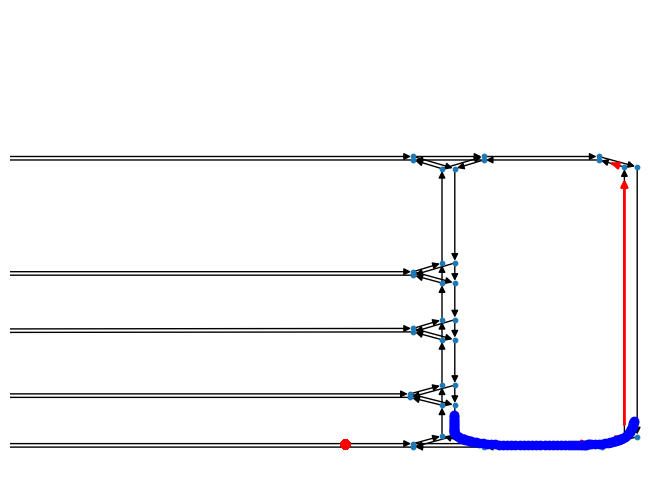

Reached the pose: [395.08110385  27.92305714   4.61079633]
Distance to target: 291.12976369696 meters


In [ ]:
# Example usage
current_state = np.concatenate((ego_vehicle_pos,np.array(np.pi/2).reshape(1,))) # Initial state (x, y, theta)

obstacles = []  # List of obstacle positions

# Draw the graph with nodes and path edges
nx.draw(G, node_positions,node_size=10)
nx.draw_networkx_edges(G, node_positions, edgelist=path_edges, edge_color='r', width=2)

path_loop = [G.nodes[path[i+1]]["vertex"] for i in range(len(path)-1)]
next_waypoint = path_loop.pop(0)

# get the position of the other vehicle
x,y  = get_actor_T_world('other_vehicle', 0)[:2,-1]
# here we assume that the other vehicle is moving with a constant longitudinal velocity and no lateral velocity
dynamic_obstacles = [(x,y,13.8,0.0)]


i=0
while path_loop and i<100:
    # Check if the current state is close to the next waypoint and update the next waypoint
    if np.linalg.norm(current_state - np.array(next_waypoint)) < 5.0:
        next_waypoint = path_loop.pop(0)

    # Compute the trajectory using dynamic window approach and avoidance
    resulting_trajectory  = dynamic_window_approach_avoidance(current_state, np.array(next_waypoint), obstacles, dynamic_obstacles)

    # Move along the trajectory (simulated) and plot the trajectory
    current_state = resulting_trajectory[1]
    i+=1
    plt.plot(current_state[0], current_state[1], 'bo')

# Set the limits of the plot
plt.xlim(200,400)
plt.ylim(-50,500)
plt.show()

print("Reached the pose:", current_state)
print("Distance to target:", np.linalg.norm(current_state - np.array(next_waypoint)), "meters")